In [1]:
import pandas as pd
import numpy as np
import talib as ta
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from scipy.signal import argrelextrema
import json
from bs4 import BeautifulSoup
import requests 
import urllib.request
import datetime
from datetime import timedelta, datetime
import time
diretorio= os.getcwd()
diretorio

'/Users/igoracmorais/igor/Wise&Trust/CPM_trading2/Trading/Rotines/Python'

In [252]:
data=pd.read_csv(diretorio+"/btc.csv",sep=";",index_col="datetime")
def macd(data,n=200,nome_coluna_datas="datetime",EMA_fast=[],EMA_slow=[]):
    for a in EMA_fast:
        for b in EMA_slow:
            data['macd'+str(a)+str(b)],data['macdsignal'+str(a)+str(b)],data['macdhist'+str(a)+str(b)]=ta.MACD(data.close,
                                                                                                               fastperiod=a,
                                                                                                               slowperiod=b,
                                                                                                               signalperiod=9)
            data['EMA'+str(b)]=ta.EMA(data.close,timeperiod=b)
        data['EMA'+str(a)]=ta.EMA(data.close,timeperiod=a)
    return data

In [222]:
# Candlestick graph
def candle_graph(data,n=200,nome_coluna_datas="datetime",coluna_macdisthist="macdhist",
                 coluna_macdsignal="macdsignal",EMA_fast=[],EMA_slow=[]):
    ohlc=data.reset_index()[-n:]
    ohlc[nome_coluna_datas]=pd.to_datetime(ohlc[nome_coluna_datas])
    ohlc[nome_coluna_datas]=ohlc[nome_coluna_datas].apply(mdates.date2num)
    #
    plt.style.use('fivethirtyeight')
    fig = plt.figure(figsize=(6,8)) 
    ax1 = plt.subplot2grid((6,1), (0, 0),rowspan=3)
    ax2 = plt.subplot2grid((6,1), (3, 0),rowspan=2)
    ax3 = plt.subplot2grid((6,1), (5, 0),rowspan=1)
    ax1.axes.get_xaxis().set_visible(False)
    ax2.axes.get_xaxis().set_visible(False)
    candlestick_ohlc(ax1, ohlc.values, width=.6, colorup='green', colordown='red')
    g1,=ax1.plot(ohlc[nome_coluna_datas],ohlc['EMA'+str(EMA_fast)],lw=1,label='EMA'+str(EMA_fast),color='black')
    g2,=ax1.plot(ohlc[nome_coluna_datas],ohlc['EMA'+str(EMA_slow)],lw=1,label='EMA'+str(EMA_slow),color='blue')
    # macdhist
    pos_signal = ohlc[coluna_macdisthist].copy()
    neg_signal = ohlc[coluna_macdisthist].copy()
    pos_signal[pos_signal <= 0] = np.nan
    neg_signal[neg_signal > 0] = np.nan
    ax2.bar(ohlc[nome_coluna_datas], pos_signal, color = 'green', lw=1,label="macdhist")
    ax2.bar(ohlc[nome_coluna_datas], neg_signal, color = 'red', lw=1)
    # macdsignal
    ax3.plot(ohlc[nome_coluna_datas],ohlc[coluna_macdsignal],lw=1,label="macdsignal",color='black')
    ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    import matplotlib.ticker as ticker
    ax3.xaxis.set_major_locator(ticker.MaxNLocator(10))
    plt.xticks(fontsize=8)
    #
    ax1.legend((g1,g2),['EMA'+str(EMA_fast),'EMA'+str(EMA_slow)],loc="best",fontsize=8)
    ax2.legend(loc=1,fontsize=8)
    ax3.legend(loc=1,fontsize=8)
    return plt.show()

In [262]:
def turning_point(data,coluna=[],ordem=3):
    for coluna in coluna:
        data[coluna+'_min'] = data.iloc[argrelextrema(data[coluna].values, 
                                                  np.less_equal, order=ordem)[0]][coluna]
        data[coluna+'_max'] = data.iloc[argrelextrema(data[coluna].values, 
                                                  np.greater_equal, order=ordem)[0]][coluna]
        data[coluna+'_min'].fillna(0,inplace=True)
        data[coluna+'_max'].fillna(0,inplace=True)
        data["tp_"+coluna]=0
        data.loc[data[coluna+'_min']>0,"tp_"+coluna]=1
        data.loc[data[coluna+'_max']>0,"tp_"+coluna]=-1
        data[[coluna+'_min',coluna+'_max']]=np.nan
        data.drop([coluna+'_min',coluna+'_max'],axis=1,inplace=True)
    return data

## exemplo

In [263]:
df=macd(data,EMA_fast=12,EMA_slow=26)
df=turning_point(df,coluna=["macd","macdsignal","macdhist"])
df.tail(4)

/Users/igoracmorais/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, plus)
/Users/igoracmorais/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in less_equal
  results &= comparator(main, minus)
/Users/igoracmorais/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:68: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, plus)
/Users/igoracmorais/anaconda3/lib/python3.6/site-packages/scipy/signal/_peak_finding.py:69: RuntimeWarning: invalid value encountered in greater_equal
  results &= comparator(main, minus)


,open,high,low,close,volume,macd,macdsignal,macdhist,EMA12,EMA26,tp_close,tp_macdhist,tp_macd,tp_macdsignal
datetime,,,,,,,,,,,,,,
2018-10-13,6252.10,6280.73,6238.92,6267.27,1.377050e+08,-61.925808,-25.310928,-36.614880,6457.530621,6519.456429,0,0,0,0
2018-10-14,6267.27,6346.56,6247.17,6277.73,2.154229e+08,-71.681781,-34.585099,-37.096682,6429.868987,6501.550768,0,0,0,0
2018-10-15,6277.73,7234.83,6244.77,6612.36,1.190524e+09,-51.814332,-38.030945,-13.783386,6457.944528,6509.758859,-1,0,0,0
2018-10-16,6612.69,6612.99,6583.30,6606.12,8.020117e+06,-36.155967,-37.655950,1.499982,6480.740754,6516.896721,0,-1,0,0


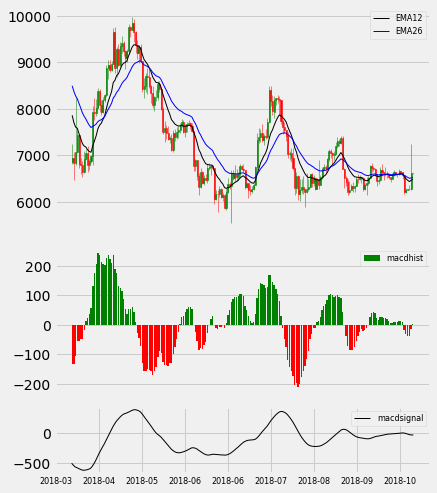

In [264]:
candle_graph(df,EMA_fast=12,EMA_slow=26)